In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
tf.__version__, tfds.__version__

('2.15.0', '4.9.4')

In [3]:
(train_data, validation_data, test_data), ds_info = tfds.load(
    "cassava",
    split=["train", "validation", "test"],
    shuffle_files=True,
    batch_size=32,
    download=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incomplete3YQ5BX/cassava-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incomplete3YQ5BX/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incomplete3YQ5BX/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [4]:
class_names = ds_info.features["label"].names
class_names

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [5]:
def preprocess_img(img, label, target_img_shape=384):
  img = tf.image.resize(img, size=(target_img_shape, target_img_shape))
  return tf.cast(img, tf.float32), label # return (float_32_img, label) tuple

In [6]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # .shuffle(buffer_size=1000) #.prefetch(1) #.batch(32)
validation_data = validation_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) #.batch(32)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) #.batch(32)

In [7]:
train_data

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
# Turn on mixed precision training
from keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [9]:
# Create a model
IMG_SHAPE = (384, 384)

# Create a base model
base_model = keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable = False

# Create functiional model
inputs = keras.layers.Input((384, 384, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(len(class_names),)(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

82420632/82420632 [==============================] - 0s 0us/step


In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"])

In [11]:
history = model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.15*len(validation_data))
)

Epoch 1/10
177/177 [==============================] - 84s 302ms/step - loss: 0.9217 - accuracy: 0.6616 - val_loss: 0.7924 - val_accuracy: 0.6806
Epoch 2/10
177/177 [==============================] - 42s 234ms/step - loss: 0.7196 - accuracy: 0.7450 - val_loss: 0.7174 - val_accuracy: 0.7049
Epoch 3/10
177/177 [==============================] - 39s 221ms/step - loss: 0.6548 - accuracy: 0.7716 - val_loss: 0.6756 - val_accuracy: 0.7361
Epoch 4/10
177/177 [==============================] - 40s 224ms/step - loss: 0.6222 - accuracy: 0.7829 - val_loss: 0.6787 - val_accuracy: 0.7361
Epoch 5/10
177/177 [==============================] - 39s 222ms/step - loss: 0.5949 - accuracy: 0.7951 - val_loss: 0.6364 - val_accuracy: 0.7604
Epoch 6/10
177/177 [==============================] - 39s 217ms/step - loss: 0.5740 - accuracy: 0.8032 - val_loss: 0.6560 - val_accuracy: 0.7535
Epoch 7/10
177/177 [==============================] - 41s 230ms/step - loss: 0.5593 - accuracy: 0.8080 - val_loss: 0.6514 - val_ac

In [12]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-27 18:05:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-27 18:05:45 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [13]:
from helper_functions import plot_loss_curves

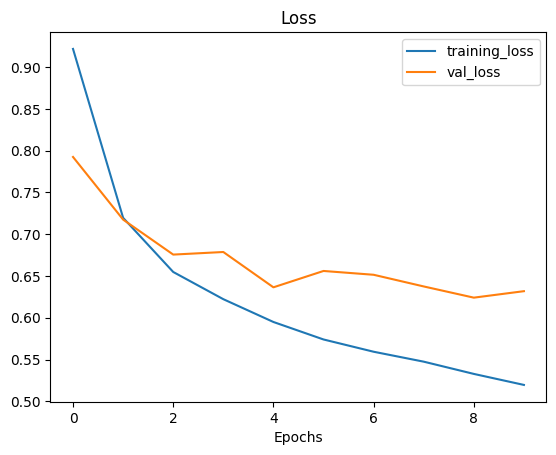

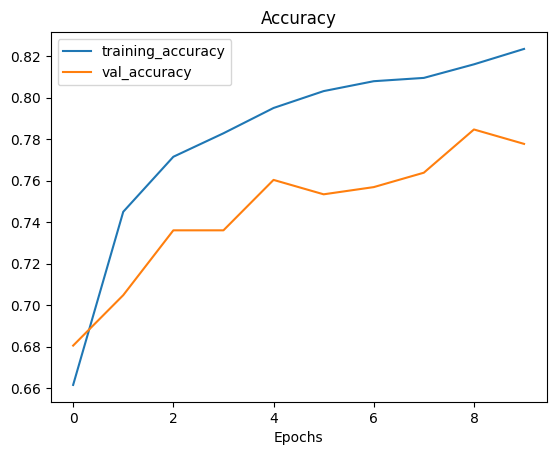

In [14]:
plot_loss_curves(history)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
Total params: 20337765 (77.58 MB)
Trainable params: 6405 (25.

In [21]:
result_before_fine_tuning = model.evaluate(test_data)

59/59 [==============================] - 21s 355ms/step - loss: 0.5200 - accuracy: 0.8202


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)
filepath = "best.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch'
)

In [17]:
model.save_weights("before_fine_tuning.weights.h5")

In [22]:
history_fine_tuned = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=int(0.15*len(validation_data)),
    callbacks=[early_stopping, model_checkpoint],
    initial_epoch=history.epoch[-1]
)

Epoch 10/100
177/177 [==============================] - 42s 237ms/step - loss: 0.5167 - accuracy: 0.8236 - val_loss: 0.6244 - val_accuracy: 0.7951
Epoch 11/100
177/177 [==============================] - 44s 246ms/step - loss: 0.5060 - accuracy: 0.8280 - val_loss: 0.6093 - val_accuracy: 0.7917
Epoch 12/100
177/177 [==============================] - 42s 233ms/step - loss: 0.4955 - accuracy: 0.8322 - val_loss: 0.5847 - val_accuracy: 0.8125
Epoch 13/100
177/177 [==============================] - 39s 221ms/step - loss: 0.4895 - accuracy: 0.8342 - val_loss: 0.5940 - val_accuracy: 0.8021
Epoch 14/100
177/177 [==============================] - 39s 222ms/step - loss: 0.4851 - accuracy: 0.8354 - val_loss: 0.6120 - val_accuracy: 0.7812
Epoch 15/100
177/177 [==============================] - 40s 222ms/step - loss: 0.4803 - accuracy: 0.8393 - val_loss: 0.5880 - val_accuracy: 0.7847


In [24]:
results_fine_tuned = model.evaluate(test_data)
model.save_weights("fine_tuned.weights.h5")

59/59 [==============================] - 13s 210ms/step - loss: 0.5061 - accuracy: 0.8196


In [25]:
model.load_weights(filepath)
model.evaluate(test_data)

59/59 [==============================] - 12s 204ms/step - loss: 0.5065 - accuracy: 0.8170


[0.5065224170684814, 0.8169761300086975]